In [1]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt

In [2]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"

DATA_FILE = DATA_DIR / "motley-fool-data.pkl"

DATA_FILE

WindowsPath('C:/Users/ssmyt/earnings-call-nlp/data/motley-fool-data.pkl')

In [3]:
with open(DATA_FILE, "rb") as f:
    data = pickle.load(f)
type(data)

pandas.core.frame.DataFrame

In [4]:
df = data.copy()
df.shape

(18755, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18755 entries, 0 to 18754
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        18755 non-null  object
 1   exchange    18755 non-null  object
 2   q           18755 non-null  object
 3   ticker      18755 non-null  object
 4   transcript  18755 non-null  object
dtypes: object(5)
memory usage: 732.7+ KB


In [6]:
#Check to see how dates are formatted 
df["date"].head()

0    Aug 27, 2020, 9:00 p.m. ET
1    Jul 30, 2020, 4:30 p.m. ET
2    Oct 23, 2019, 5:00 p.m. ET
3    Nov 6, 2019, 12:00 p.m. ET
4     Aug 7, 2019, 8:30 a.m. ET
Name: date, dtype: object

In [7]:
#See how many dates cant be  coerced into datetime object
import warnings

# Use this magic command at the top of your specific code cell
# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Perform the calculation and assign the result to the variable
invalid_count = pd.to_datetime(df['date'], errors='coerce').isna().sum()
invalid_count

C:\Users\ssmyt\AppData\Local\Temp\ipykernel_9644\3713727637.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  invalid_count = pd.to_datetime(df['date'], errors='coerce').isna().sum()


380

# Clean dates 

In [11]:
# data types in date column some are strings and some are lists
df['date'].apply(type).value_counts()

date
<class 'str'>     18376
<class 'list'>      379
Name: count, dtype: int64

In [17]:
#for the dates with a list find the ET where time is located
mask_lst = df['date'].apply(lambda x: isinstance(x, list))
first_list = df[mask_lst]['date'].iloc[0]
print(first_list) 
mask_str = df['date'].apply(lambda x: isinstance(x, str))
first_str = df[mask_str]['date'].iloc[0]
print(first_str) 


['Brunswick (BC 0.66%) Q4 2018 ', 'Jan. 31, 2019 11:00 a.m. ET']
Aug 27, 2020, 9:00 p.m. ET


In [18]:
#Method to clean dates
import pandas as pd
import re
import ast

def parse_clean_date(x):
    
    date_str = None
    
    if isinstance(x, list):
        for item in x:
            if isinstance(item, str) and "ET" in item:
                date_str = item
                break
    
    elif isinstance(x, str):
        # Stringified list?
        if x.startswith("[") and x.endswith("]"):
            try:
                items = ast.literal_eval(x)
                for item in items:
                    if isinstance(item, str) and "ET" in item:
                        date_str = item
                        break
            except:
                return pd.NaT
        else:
            date_str = x
    else:
        return pd.NaT

    if date_str is None:
        return pd.NaT

    date_str = re.sub(r"\sET$", "", date_str)        # remove ET
    date_str = date_str.replace("a.m.", "AM").replace("p.m.", "PM")  # normalize AM/PM
    date_str = date_str.replace('.', '')             # remove dots in month abbreviation

    try:
        return pd.to_datetime(date_str)
    except:
        return pd.NaT



In [22]:
df["call_datetime"] = df["date"].apply(parse_clean_date)

C:\Users\ssmyt\AppData\Local\Temp\ipykernel_9644\1948113217.py:40: UserWarning: Parsing dates in Sept %d, %Y, %m:%M %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str)


In [23]:
# reduces missing to 5 dates
print(f"Bad Dates: {df['call_datetime'].isna().sum()}")
print(f"Valid dates:   {df['call_datetime'].notna().sum()}")

Bad Dates: 5
Valid dates:   18750


In [33]:
failures = df[df['call_datetime'].isna()][['date', 'call_datetime', 'ticker']].reset_index(drop=True)
failures[['date', 'ticker']]

,date,ticker
0,,XPO
1,[Ethan Allen Interiors Inc (ETD -0.17%)Q2 201...,ETD
2,[Moog Inc. (MOG.A 0.77%) (MOG.B)Q2 2021 Earnin...,MOG.A
3,[Rush Enterprises Inc (RUSHA -1.94%) (RUSHB -3...,RUSHA
4,"[TTEC Holdings, Inc. (TTEC -0.52%)TTEC Holding...",TTEC


In [56]:
#drop the 5 invalid datetime rows
df = df.dropna(subset=['call_datetime']).copy()

In [57]:
df["call_datetime"].isna().sum() # no bad dates remaining

0

# EDA

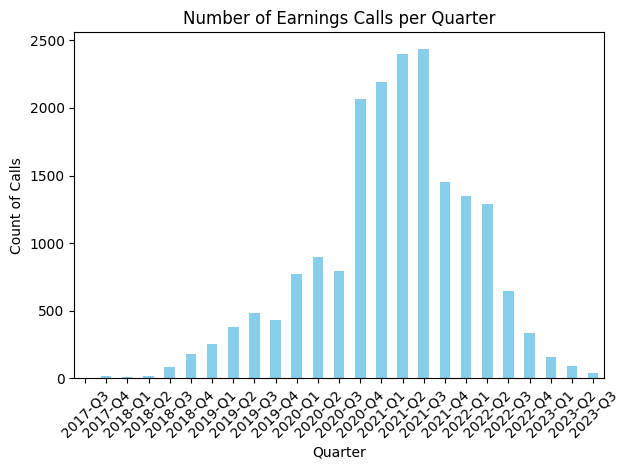

In [58]:
# data seems to be primarily from 2020 -2021 
quarter_counts = df['q'].value_counts()
quarter_counts = quarter_counts.sort_index()

quarter_counts.plot(kind='bar', color='skyblue')

plt.title('Number of Earnings Calls per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count of Calls')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

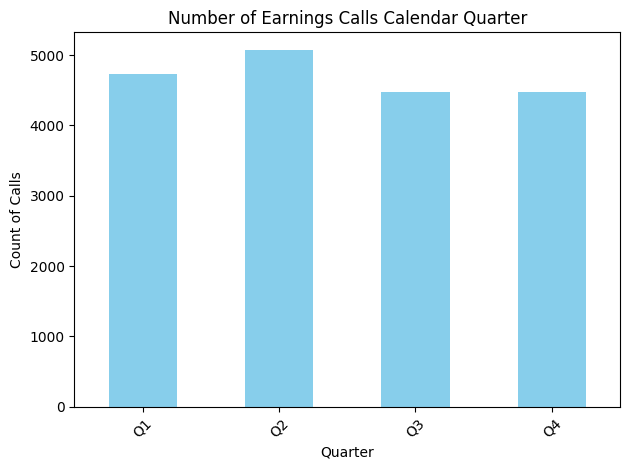

In [59]:
# relatively balanced throughout year
df['quarter_only'] = df['q'].str.split('-').str[1]
qonly_counts = df['quarter_only'].value_counts()
qonly_counts = qonly_counts.sort_index()

qonly_counts.plot(kind='bar', color='skyblue')

plt.title('Number of Earnings Calls Calendar Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count of Calls')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()



# Clean transcript

In [60]:
#Inspect tbe transcript column
df.loc[0, "transcript"][:1000]

"Prepared Remarks:\nOperator\nGood day, and welcome to the Bilibili 2020 Second Quarter Earnings Conference Call. Today's conference is being recorded.\nAt this time, I would like to turn the conference over to Juliet Yang, Senior Director of Investor Relations. Please go ahead.\nJuliet Yang -- Senior Director of Investor Relations\nThank you, operator.\nPlease note the discussion today will contain forward-looking statements relating to the Company's future performance, and are intended to qualify for the Safe Harbor from liability, as established by the US Private Securities Litigation Reform Act. Such statements are not guarantees of future performance and are subject to certain risks and uncertainties, assumptions and other factors. Some of these risks are beyond the Company's control and could cause actual results to differ materially from those mentioned in today's press release and this discussion. A general discussion of the risk factors that could affect Bilibili's business an

In [61]:
def clean_transcript_basic(text):
    if not isinstance(text, str):
        return ""

    # Fix common encoding artifacts
    text = text.replace("\xa0", " ")

    # Normalize Windows/Mac newlines to \n
    text = text.replace("\r\n", "\n").replace("\r", "\n")

    # Collapse multiple blank lines into a single newline
    text = re.sub(r"\n{2,}", "\n", text)

    # Strip leading/trailing whitespace on each line
    lines = [line.strip() for line in text.split("\n")]

    # Rejoin preserving line structure
    text = "\n".join(lines)

    return text


In [62]:
#samople only 500 rows for managability 
df_sample = df.sample(n=500, random_state=42).copy()
df_sample = df_sample.reset_index(drop=True)

In [63]:
df_sample['transcript_clean_basic'] = df_sample['transcript'].apply(clean_transcript_basic)

In [64]:
#remove forward looking statements, safe harbor operator instructions   for later nlp possibly
def clean_transcript_nlp(text):
    lines = text.split("\n")
    cleaned_lines = []
    
    for line in lines:
        line = line.strip()
        if not line:
            continue  # skip empty lines

        # Remove boilerplate / legal / operator lines
        if re.search(r"^Prepared Remarks|^Operator|forward-looking statements|Safe Harbor|\[Operator instructions\]", line, re.I):
            continue

        # Keep speaker headers like "Name -- Title"
        
        cleaned_lines.append(line)

    # Join lines with single space or newline
    cleaned_text = " ".join(cleaned_lines)
    
    
    cleaned_text = re.sub(r"\s+", " ", cleaned_text)
    
    return cleaned_text


In [65]:
df_sample["transcript_nlp"] = df_sample["transcript"].apply(clean_transcript_nlp)

In [67]:
print(df_sample.iloc[0]["transcript_nlp"][:300])

Good afternoon, ladies and gentlemen. My name is Brent, and I will be your conference operator today. I would like to welcome everyone to the Gap Inc. third quarter 2022 earnings conference call. Cammeron McLaughlin -- Head of Investor Relations Bobby Martin -- Chief Executive Officer Thank you, Cam


In [68]:
print(df_sample.iloc[0]["transcript"][:300])

Prepared Remarks:
Operator
Good afternoon, ladies and gentlemen. My name is Brent, and I will be your conference operator today. I would like to welcome everyone to the Gap Inc. third quarter 2022 earnings conference call.
[Operator instructions] I would now like to introduce your host, Cammeron McL


In [69]:
#remove on average approx 1400 words removed
(df_sample['transcript_clean_basic'].str.len() - df_sample['transcript_nlp'].str.len()).describe()

count     500.000000
mean     1392.974000
std       585.312682
min        28.000000
25%      1013.000000
50%      1336.500000
75%      1715.750000
max      4151.000000
dtype: float64

In [70]:
df_sample.iloc[(df_sample['transcript_clean_basic'].str.len() - df_sample['transcript_nlp'].str.len()).idxmax()][['transcript_clean_basic','transcript_nlp']]

transcript_clean_basic    Prepared Remarks:\nOperator\nGood day and welc...
transcript_nlp            I would now like to turn the call over to Beth...
Name: 476, dtype: object

In [71]:
df_sample.iloc[(df_sample['transcript_clean_basic'].str.len() - df_sample['transcript_nlp'].str.len()).idxmin()][['transcript_clean_basic','transcript_nlp']]

transcript_clean_basic    Prepared Remarks:\nCarla Dodsworth Albano Mill...
transcript_nlp            Carla Dodsworth Albano Miller -- Investor Rela...
Name: 143, dtype: object

In [72]:
def split_qna_strict(text):
    # Normalize invisible spaces
    text = text.replace("\xa0", " ")
    
    lines = text.split("\n")
    
    # Regex for strict Q&A header, allowing "&" or "and"
    pattern = re.compile(r"^Questions\s*(?:&|and)\s*Answers\s*:", re.I)
    
    for i, line in enumerate(lines):
        line_clean = line.strip()
        if pattern.search(line_clean):
            return {
                "prepared_remarks": "\n".join(lines[:i]),
                "qna": "\n".join(lines[i:])
            }
    
    # If no explicit Q&A header is found
    return {
        "prepared_remarks": text,
        "qna": ""
    }


In [73]:
sections = df_sample["transcript"].apply(split_qna_strict)

df_sample["prepared_remarks"] = sections.apply(lambda x: x["prepared_remarks"])
df_sample["qna"] = sections.apply(lambda x: x["qna"])

df_sample["prepared_len"] = df_sample["prepared_remarks"].str.len()
df_sample["qna_len"] = df_sample["qna"].str.len()


In [74]:
(df_sample["qna_len"] > 0).value_counts()

qna_len
True     497
False      3
Name: count, dtype: int64

In [78]:
# find roiws where not find q and a section
noqna = df_sample[df_sample["qna_len"] == 0]
noqna

,date,exchange,q,ticker,transcript,call_datetime,quarter_only,transcript_clean_basic,transcript_nlp,prepared_remarks,qna,prepared_len,qna_len
108,"May 10, 2022, 5:00 p.m. ET",NASDAQ: RXT,2022-Q1,RXT,Prepared Remarks:\nJoseph Crivelli\nGood after...,2022-05-10 17:00:00,Q1,Prepared Remarks:\nJoseph Crivelli\nGood after...,"Joseph Crivelli Good afternoon, and welcome to...",Prepared Remarks:\nJoseph Crivelli\nGood after...,,33385,0
213,"Feb 08, 2022, 5:00 p.m. ET",NASDAQ: XP,2021-Q4,XP,"Prepared Remarks:\nAndre Martins\nEveryone, we...",2022-02-08 17:00:00,Q4,"Prepared Remarks:\nAndre Martins\nEveryone, we...","Andre Martins Everyone, we're just waiting for...","Prepared Remarks:\nAndre Martins\nEveryone, we...",,61455,0
319,"Jan 19, 2023, 6:00 p.m. ET",NASDAQ: NFLX,2022-Q4,NFLX,Prepared Remarks:\nSpencer Wang\nGood afternoo...,2023-01-19 18:00:00,Q4,Prepared Remarks:\nSpencer Wang\nGood afternoo...,"Spencer Wang Good afternoon, and welcome to th...",Prepared Remarks:\nSpencer Wang\nGood afternoo...,,51642,0


In [84]:
no_qna = df_sample[df_sample['qna_len'] == 0]

# Inspect first one
first_no_qna = no_qna.iloc[0]

print("Ticker:", first_no_qna['ticker'])
print("Prepared Remarks Length:", len(first_no_qna['prepared_remarks']))
print("Q&A Length:", len(first_no_qna['qna']))
print("\nExcerpt from transcript:")

Ticker: RXT
Prepared Remarks Length: 33385
Q&A Length: 0

Excerpt from transcript:


In [103]:
first_no_qna

date                                             Feb 10, 2021, 5:00 p.m. ET
exchange                                                       NASDAQ: QLYS
q                                                                   2020-Q4
ticker                                                                 QLYS
transcript                Prepared Remarks:\nOperator\nLadies and gentle...
call_datetime                                           2021-02-10 17:00:00
quarter_only                                                             Q4
transcript_clean_basic    Prepared Remarks:\nOperator\nLadies and gentle...
transcript_nlp            I will now turn the conference over to Mr. Vin...
prepared_remarks_nlp      Prepared Remarks:\nOperator\nLadies and gentle...
qna_nlp                   Questions and Answers:\nOperator\nThank you. [...
prepared_len                                                          55881
qna_len                                                                   0
prepared_rem

In [85]:
print(df_sample[['prepared_len', 'qna_len']].describe())

       prepared_len       qna_len
count    500.000000    500.000000
mean   19792.824000  27508.952000
std     7187.351825  12027.504408
min     1306.000000      0.000000
25%    14995.500000  18690.500000
50%    19178.000000  27340.000000
75%    23507.250000  35127.750000
max    61455.000000  76161.000000


In [88]:
# dropthe rows where can't find q and a section
df_sample = df_sample[df_sample["qna_len"] != 0]
print(df_sample.shape)

(497, 13)


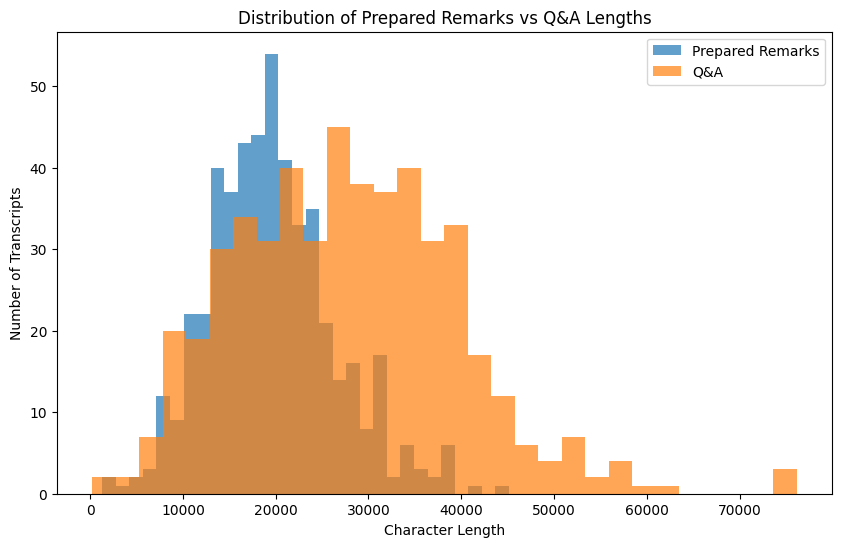

In [89]:
plt.figure(figsize=(10,6))
plt.hist(df_sample['prepared_len'], bins=30, alpha=0.7, label='Prepared Remarks')
plt.hist(df_sample['qna_len'], bins=30, alpha=0.7, label='Q&A')

plt.xlabel("Character Length")
plt.ylabel("Number of Transcripts")
plt.title("Distribution of Prepared Remarks vs Q&A Lengths")
plt.legend()
plt.show()

In [93]:
df_file = DATA_DIR / "earnings_calls_cleaned.csv"
df_sample.to_csv(df_file, index=False)